<h1> Business Analytics</h1>
<h2> Marketing Analysis - A/B tests </h2>
<h3> <strong>Páginas com avaliações de usuários aumentam a quantidade de vendas? - A/B tests </strong></h3>

In [1]:
import datetime
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs

plt.style.use('fivethirtyeight')
plt.figure(1, figsize = (15, 6))
%matplotlib inline

In [2]:
%reload_ext watermark
%watermark -a "dijkstra001" --iversions

Author: dijkstra001

matplotlib: 3.3.2
numpy     : 1.19.2
scipy     : 1.5.2
pandas    : 1.1.3



In [3]:
dataset = pd.read_csv('dataset.csv')
dataset.head()

,id,variante,compra,data
0,0x6f9421,A,False,2019-12-26
1,0x59d442,A,False,2019-08-16
2,0x6db8f8,A,True,2019-03-18
3,0x68245d,A,False,2019-02-13
4,0x28566e,A,False,2019-09-28


<p> <strong style="color: blue">Variante A: </strong>Mostra o nº atual de comentários e avaliações de usuários. É a <strong>variante de controle</strong>.</p>
<strong style="color: red">Variante B: </strong>Não mostra os comentários e avaliações no site. É a <strong>variante de teste</strong>.</p>

<h2> Análise do conjunto de dados:</h2>

In [4]:
data_max = dataset['data'].max()
data_min = dataset['data'].min()
print(f'Data máxima: {data_max} e Data mínima: {data_min}')

Data máxima: 2020-01-30 e Data mínima: 2019-01-01


In [5]:
dataset.isnull().sum()

id          0
variante    0
compra      0
data        0
dtype: int64

In [6]:
dataset.id.value_counts().sum()

55000

In [7]:
dataset.compra.value_counts()

False    46416
True      8584
Name: compra, dtype: int64

In [8]:
dataset.variante.value_counts()

A    50000
B     5000
Name: variante, dtype: int64

<h2> Calculando probabilidades de:</h2>

<p><strong>1 - Probabilidade de um usuário visualizar a variante A:</strong></p>

In [9]:
round((dataset[dataset.variante == 'A'].shape[0] / dataset.shape[0]) * 100, 2)

90.91

<p><strong>2 - Probabilidade de um usuário visualizar a variante B:</strong></p>

In [10]:
round((dataset[dataset.variante == 'B'].shape[0] / dataset.shape[0]) * 100, 2)

9.09

<p><strong>3 - Se um indivíduo estava no grupo de controle (variante A), qual a probabilidade de conversão de compra:</strong></p>

In [11]:
round((dataset[dataset.variante == 'A'].compra.mean()) * 100, 2)

15.21

<p><strong>Total de compras realizadas:</strong></p>

In [12]:
dataset.compra.sum()

8584

<p><strong>Total de compras realizadas quando a variante era A:</strong></p>

In [13]:
dataset[dataset.variante == 'A'].compra.sum()

7603

<p><strong>Total de compras realizadas quando a variante era B:</strong></p>

In [14]:
dataset[dataset.variante == 'B'].compra.sum()

981

<p><strong>4 - Probabilidade de conversão de compras, independente da variante recebida:</strong></p>

In [15]:
round((dataset.compra.mean()) * 100, 2)

15.61

<p><strong>5 - Probabilidade de conversão de compras, dado uma variante de controle:</strong></p>

In [16]:
A = round((dataset[dataset.variante == 'A'].compra.mean()) * 100, 2)
print(A)

15.21


<p><strong>6 - Probabilidade de conversão de compras, dado uma variante de tratamento:</strong></p>

In [17]:
B = round((dataset[dataset.variante == 'B'].compra.mean()) * 100, 2)
print(B)

19.62


<p> Com base nos cálculos de probabilidades realizados, precisamos analisar se temos evidências suficientes para determinarmos se a variável de teste pode causar um aumento de conversão de compras. Os dados demonstraram que, <strong>apesar de pouca visibilidade da variante B</strong>, a taxa de conversão dessa variante é superior à variante de controle (A). </p>
<p> Nesse sentido, é necessário uma análise mais detalhada para identificarmos os padrões desse comportamento.</p>

<h1 style="color: blue">Tarefa 1 - Configurando o experimento</h1>
<p>Considere que você precisa tomar uma decisão apenas com base nos dados fornecidos. Se você quiser assumir que a variante A é a melhor, a menos que a nova variante prove ser definitivamente melhor em uma taxa de erro <strong>Tipo I de 5%</strong>, quais deveriam
ser as suas hipóteses nula e alternativa?</p>
<ul>
    <li>H0: PB - PA = 0</li>
    <li>H1: PB - PA > 0</li>
</ul>

<p><strong style="color: green">H0</strong> nos diz que a diferença de probabilidade dos dois grupos é igual a zero.</p>
<p><strong style="color: red">H1</strong> nos diz que a diferença de probabilidade dos dois grupos é maior que zero.</p>

<h3 style="color: blue">Pré-Processamento dos dados:</h3>

In [18]:
def extrair_data(x):
    return x[:7]

dataset['ano_mes'] = dataset['data'].apply(extrair_data)
dataset.head()

,id,variante,compra,data,ano_mes
0,0x6f9421,A,False,2019-12-26,2019-12
1,0x59d442,A,False,2019-08-16,2019-08
2,0x6db8f8,A,True,2019-03-18,2019-03
3,0x68245d,A,False,2019-02-13,2019-02
4,0x28566e,A,False,2019-09-28,2019-09


In [19]:
dataset_2020 = dataset[dataset['ano_mes'] == '2020-01']
dataset_2020.head()

,id,variante,compra,data,ano_mes
5,0x792f1d,A,False,2020-01-14,2020-01
7,0x724b78,B,False,2020-01-23,2020-01
9,0x684bf9,A,False,2020-01-17,2020-01
10,0x6394dc,A,False,2020-01-06,2020-01
11,0x625f5d,A,False,2020-01-05,2020-01


<h3 style="color: blue">Criação do baseline:</h3>
<ul>
    <li><strong style="color: green">A</strong> será o grupo de controle.</li>
    <li><strong style="color: red">B</strong> será o grupo de teste</li>
</ul>

In [20]:
dataset_ab = dataset_2020[['variante', 'compra']]
dataset_ab.columns = ['grupo', 'conversao']
dataset_ab.head()

,grupo,conversao
5,A,False
7,B,False
9,A,False
10,A,False
11,A,False


In [21]:
dataset_ab_sumario = dataset_ab.pivot_table(values = 'conversao', index = 'grupo', aggfunc = np.sum)
dataset_ab_sumario.head()

,conversao
grupo,
A,587
B,981


In [22]:
dataset_ab_sumario['total'] = dataset_ab.pivot_table(values = 'conversao', index = 'grupo', aggfunc = lambda x : len(x))
dataset_ab_sumario['taxa %'] = round(dataset_ab.pivot_table(values = 'conversao', index = 'grupo') * 100, 2)
dataset_ab_sumario.head()

,conversao,total,taxa %
grupo,,,
A,587,3821,15.36
B,981,5000,19.62


In [23]:
conversao_A = dataset_ab_sumario['conversao'][0]
total_A = dataset_ab_sumario['total'][0]
taxa_A = dataset_ab_sumario['taxa %'][0]
print(f'Valores do grupo A:\nConversão: {conversao_A}\nTotal: {total_A}\nTaxa: {taxa_A}')

Valores do grupo A:
Conversão: 587
Total: 3821
Taxa: 15.36


In [24]:
conversao_B = dataset_ab_sumario['conversao'][1]
total_B = dataset_ab_sumario['total'][1]
taxa_B = dataset_ab_sumario['taxa %'][1]
print(f'Valores do grupo B:\nConversão: {conversao_B}\nTotal: {total_B}\nTaxa: {taxa_B}')

Valores do grupo B:
Conversão: 981
Total: 5000
Taxa: 19.62


In [25]:
conversao_base = taxa_A

# Efeito mínimo detectável:
efeito_minimo = round(taxa_B - taxa_A, 2)
efeito_minimo

4.26

<h1 style="color: blue">Tarefa 2 - Realizando o teste de hipóteses</h1>
<p>Executamos o teste de hipóteses e registramos a taxa de sucesso de cada grupo.</p>
<p><strong>Poder estatístico = </strong>1 - &#914; (Beta)</p>
<ul>
    <li>Alfa: 0.05</li>
    <li>Beta: 0.2</li>
</ul>

In [26]:
alfa = 0.05
beta = 0.2
n = 50000

teste_binom = scs.binom(n, p = conversao_base / 100)
teste_binom_mde = scs.binom(n, p = (conversao_base + efeito_minimo) /100)

<BarContainer object of 50001 artists>

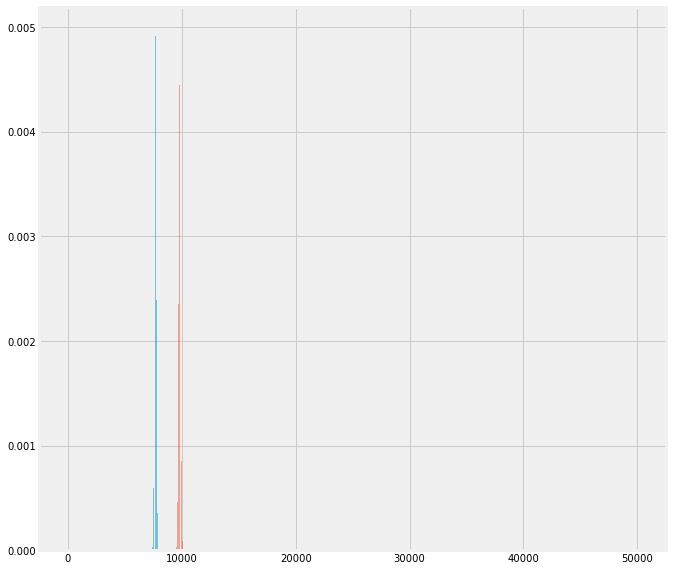

In [27]:
fig, ax = plt.subplots(figsize = (10, 10))
x = np.linspace(0, int(n), int(n) + 1)
ax.bar(x, teste_binom.pmf(x), alpha = 0.5)
ax.bar(x, teste_binom_mde.pmf(x), alpha = 0.5)

<h1 style="color: blue">Tarefa 3 - Plot da Distribuição</h1>
<p>Criação do plot da distribuição das duas amostras, com o objetivos de compararmos suas diferenças e analisarmos os resultados.</p>

Text(0, 0.5, 'Probabilidade')

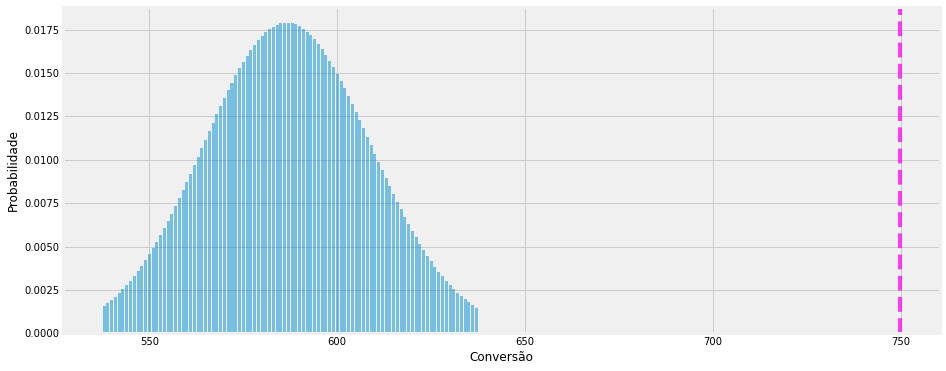

In [28]:
fig, ax = plt.subplots(figsize = (14, 6))

# Teste de A:
x = np.linspace(conversao_A - 49, conversao_A + 50, 100)
y = scs.binom(total_A, (taxa_A / 100)).pmf(x)
ax.bar(x, y, alpha = 0.5)
ax.axvline(x = (taxa_B / 100) * total_A, c = 'magenta', alpha = 0.75, linestyle = '--')
plt.xlabel('Conversão')
plt.ylabel('Probabilidade')

<BarContainer object of 100 artists>

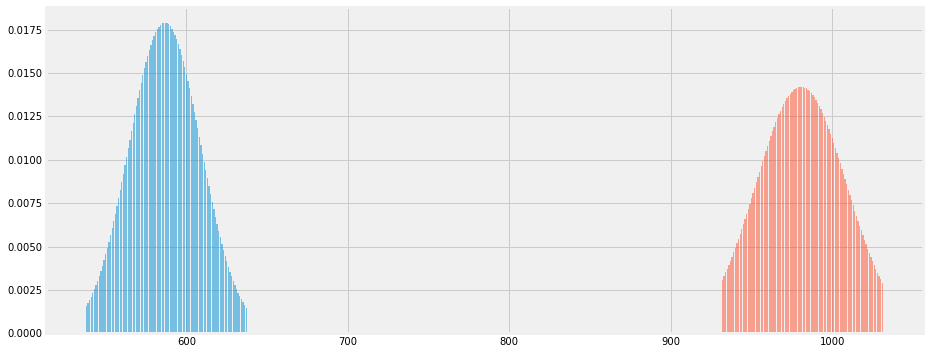

In [29]:
fig, ax = plt.subplots(figsize = (14, 6))

# Gráfico de A:
xA = np.linspace(conversao_A - 49, conversao_A + 50, 100)
yA = scs.binom(total_A, (taxa_A / 100)).pmf(xA)
ax.bar(xA, yA, alpha = 0.5)

# Gráfico de B:
xB = np.linspace(conversao_B - 49, conversao_B + 50, 100)
yB = scs.binom(total_B, (taxa_B / 100)).pmf(xB)
ax.bar(xB, yB, alpha = 0.5)